<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/autogluon/experiments/covtype_table_cls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install scikit-learn==0.23.1
%pip install --upgrade mxnet-cu101
%pip install autogluon

  Using cached https://files.pythonhosted.org/packages/d9/3a/eb8d7bbe28f4787d140bb9df685b7d5bf6115c0e2a969def4027144e98b6/scikit_learn-0.23.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: autogluon 0.0.12 has requirement scikit-learn<0.23,>=0.22.0, but you'll have scikit-learn 0.23.1 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Requirement already up-to-date: mxnet-cu101 in /usr/local/lib/python3.6/dist-packages (1.6.0)
  Using cached https://files.pythonhosted.org/packages/5e/d8/312e03adf4c78663e17d802fe2440072376fee46cada1404f1727ed77a32/scikit_learn-0.22.2.post1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
%cd /gdrive/My Drive/機械学習練習/AutoML/AutoGluon/experiments
%ls

/gdrive/My Drive/機械学習練習/AutoML/AutoGluon/experiments
covtype_table_cls.ipynb  dataset/  models/


# Predicting Columns in a Table - In Depth
テーブルデータを使った予測の練習[https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-indepth.html]([https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-indepth.html)

In [4]:
import datetime, os

import numpy as np
import pandas as pd

import autogluon as ag
from autogluon import TabularPrediction as task
from autogluon.task.tabular_prediction import TabularDataset
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split

## データの読み込み

In [5]:
SEED = 2

fetch_data = fetch_covtype(random_state=SEED)

train_X, test_X, train_y, test_y = train_test_split(fetch_data.data, fetch_data.target-1,
                                                    test_size=0.2, random_state=SEED)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  test_size=0.2, random_state=SEED)
print('train_X:{}, train_y:{}'.format(train_X.shape, train_y.shape))
print('val_X:{}, val_y:{}'.format(val_X.shape, val_y.shape))
print('test_X:{}, test_y:{}'.format(test_X.shape, test_y.shape))

label_col = 'class'
f_cols = []
for i in range(train_X.shape[1]):
  f_cols.append('f_'+str(i+1))

train_X:(371847, 54), train_y:(371847,)
val_X:(92962, 54), val_y:(92962,)
test_X:(116203, 54), test_y:(116203,)


### モデルの入力形式に合わせたデータの変型

In [6]:
def convert_to_TabularDataset(X, y, f_cols, y_col):
  df = pd.DataFrame(data=X,columns=f_cols)
  df.insert(loc=0, column=y_col, value=y)
  return TabularDataset(df = df)

In [7]:
train_td = convert_to_TabularDataset(train_X, train_y, f_cols, label_col)
val_td = convert_to_TabularDataset(val_X, val_y, f_cols, label_col)
test_td = convert_to_TabularDataset(test_X, test_y, f_cols, label_col)
print('データの型:{}'.format(type(train_td)))

データの型:<class 'autogluon.task.tabular_prediction.dataset.TabularDataset'>


## 予めモデルの構造(ハイパーパラメータ)を指定する場合

### モデルの構造を指定
パラメータ探索空間の指定方法や種類について：[https://autogluon.mxnet.io/api/autogluon.space.html](https://autogluon.mxnet.io/api/autogluon.space.html)

In [8]:
nn_options = { # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10, # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True), # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'), # activation function used in NN (categorical hyperparameter, default = first entry)
    #'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),
      # Each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1), # dropout probability (real-valued hyperparameter)
}

gbm_options = { # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100, # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36), # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {'NN': nn_options, 'GBM': gbm_options}  # hyperparameters of each model type
# If one of these keys is missing from hyperparameters dict, then no models of that type are trained.

### 実験の詳細を指定

In [9]:
# 実験の最大許容時間の設定
time_limits = 60  #@param {type: "number"}
# いくつのモデルを試行するか
num_trials = 5  #@param {type: "string"}
# パラメータ最適化の手法
search_strategy = 'skopt' #@param {type: "string"}

# 訓練後のモデル出力先
output_directory = 'models'
model_name = 'table_cls' + datetime.datetime.now().strftime('%Y%m%d%H%M%S')
output_model_path = os.path.join(output_directory, model_name)

Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to models/table_cls20200725103114/
AutoGluon Version:  0.0.12
Train Data Rows:    100
Train Data Columns: 55
Tuning Data Rows:    100
Tuning Data Columns: 55
Preprocessing data ...
Train Data Class Count: 5
NumExpr defaulting to 2 threads.
Feature Generator processed 196 data points with 41 features
Original Features (raw dtypes):
	float64 features: 41
Original Features (inferred dtypes):
	float features: 41
Generated Features (special dtypes):
Final Features (raw dtypes):
	float features: 41
Final Features:
	float features: 41
	Data preprocessing and feature engineering runtime = 0.23s ...
AutoGluon will gauge predictive performance using evaluation metric: accuracy
To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: accuracy
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get

Time out (secs) is 27.0


	0.75	 = Validation accuracy score
	0.9s	 = Training runtime
	0.04s	 = Validation runtime
	0.7292	 = Validation accuracy score
	0.93s	 = Training runtime
	0.04s	 = Validation runtime
	0.6354	 = Validation accuracy score
	1.69s	 = Training runtime
	0.04s	 = Validation runtime
	0.6562	 = Validation accuracy score
	1.0s	 = Training runtime
	0.04s	 = Validation runtime
	0.6562	 = Validation accuracy score
	1.06s	 = Training runtime
	0.04s	 = Validation runtime
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 5


Time out (secs) is 27.0


Please either provide filename or allow plot in get_training_curves
	0.5521	 = Validation accuracy score
	0.94s	 = Training runtime
	0.01s	 = Validation runtime
	0.4583	 = Validation accuracy score
	0.72s	 = Training runtime
	0.01s	 = Validation runtime
	0.6354	 = Validation accuracy score
	0.71s	 = Training runtime
	0.01s	 = Validation runtime
	0.5	 = Validation accuracy score
	0.61s	 = Training runtime
	0.01s	 = Validation runtime
	0.5	 = Validation accuracy score
	0.57s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 59.77s of the 46.08s of remaining time.
	0.7604	 = Validation accuracy score
	0.69s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 14.89s ...


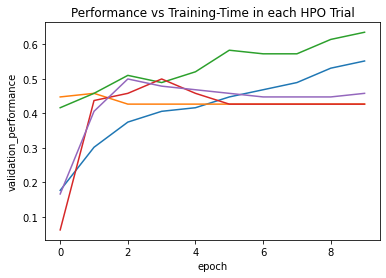

In [10]:
# 時短のためデータ量を少なくして試行してみる
predictor = task.fit(train_data=train_td.head(100), tuning_data=val_td.head(100), label=label_col,
                     problem_type='multiclass', random_seed=SEED,
                     output_directory=output_model_path, time_limits=time_limits,
                     num_trials=num_trials, hyperparameter_tune=True,
                     hyperparameters=hyperparameters, search_strategy=search_strategy)

### 結果の確認

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer
0       weighted_ensemble_k0_l1   0.760417       0.065130  2.915565                0.001406           0.692714            1       True
1    LightGBMClassifier/trial_0   0.750000       0.041214  0.897069                0.041214           0.897069            0       True
2    LightGBMClassifier/trial_1   0.729167       0.043778  0.932957                0.043778           0.932957            0       True
3    LightGBMClassifier/trial_3   0.656250       0.039238  0.999057                0.039238           0.999057            0       True
4    LightGBMClassifier/trial_4   0.656250       0.041246  1.057314                0.041246           1.057314            0       True
5   NeuralNetClassifier/trial_7   0.635417       0.011067  0.706456                0.011067           0.706456            0     

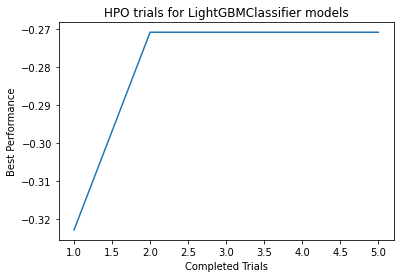

Plot summary of models saved to file: models/table_cls20200725103114/NeuralNetClassifier_HPOmodelsummary.html
Plot summary of models saved to file: NeuralNetClassifier_HPOmodelsummary.html
Plot of HPO performance saved to file: models/table_cls20200725103114/NeuralNetClassifier_HPOperformanceVStrials.png


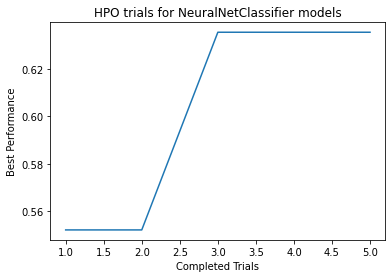

*** Details of Hyperparameter optimization ***
HPO for LightGBMClassifier model:  Num. configurations tried = 5, Time spent = 7.418692350387573, Search strategy = skopt
Best hyperparameter-configuration (validation-performance: accuracy = -0.2708333333333333):
{'feature_fraction': 0.8566939494360085, 'learning_rate': 0.009036534552604733, 'min_data_in_leaf': 18, 'num_leaves': 34}
HPO for NeuralNetClassifier model:  Num. configurations tried = 5, Time spent = 5.579728126525879, Search strategy = skopt
Best hyperparameter-configuration (validation-performance: accuracy = 0.6354166666666666):
{'activation.choice': 2, 'dropout_prob': 0.0006629628023373525, 'embedding_size_factor': 0.6448220134841547, 'layers.choice': 4, 'learning_rate': 0.0032307508333433007, 'network_type.choice': 0, 'use_batchnorm.choice': 1, 'weight_decay': 0.000617392994347252}
*** End of fit() summary ***


In [11]:
results = predictor.fit_summary()

## アンサンブルの設定を行う

In [13]:
predictor = task.fit(train_data=train_td.head(100), tuning_data=val_td.head(100), label=label_col,
                     auto_stack=True, # アンサンブルの戦略も自動で行ってほしい場合
                     #num_bagging_folds=5, stack_ensemble_levels=1, #決め打ちしたい場合
                     hyperparameters = {'NN':{'num_epochs':5}, 'GBM':{'num_boost_round':100}})

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200725_103503/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200725_103503/
AutoGluon Version:  0.0.12
Train Data Rows:    100
Train Data Columns: 55
Tuning Data Rows:    100
Tuning Data Columns: 55
Preprocessing data ...
Here are the 5 unique label values in your data:  [1, 2, 0, 5, 6]
AutoGluon infers your prediction problem is: multiclass  (because dtype of label-column == int, but few unique label-values observed).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Train Data Class Count: 5
Feature Generator processed 196 data points with 41 features
Original Features (raw dtypes):
	float64 features: 41
Original Features (inferred dtypes):
	float features: 41
Generated Features (special dtypes):
Final Features (raw dtypes):
	float features: 41
Final Features:
	float

In [15]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                            model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer
0   LightGBMClassifier_STACKER_l0   0.724490       0.049734  0.875940                0.049734           0.875940            0       True
1         weighted_ensemble_k0_l1   0.724490       0.051375  1.029071                0.001641           0.153131            1       True
2  NeuralNetClassifier_STACKER_l0   0.428571       0.084949  1.649934                0.084949           1.649934            0       True
Number of models trained: 3
Types of models trained:
{'StackerEnsembleModel_LGB', 'WeightedEnsembleModel', 'StackerEnsembleModel_TabularNeuralNet'}
Bagging used: True  (with 4 folds)
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'NN': [{'num_epochs': 5}], 'GBM': [{'num_boost_round': 100}]}}
Plot summary of models saved to fi

{'feature_prune': False,
 'hyperparameter_tune': False,
 'hyperparameters_userspecified': {'default': {'GBM': [{'num_boost_round': 100}],
   'NN': [{'num_epochs': 5}]}},
 'leaderboard':                             model  score_val  ...  stack_level  can_infer
 0   LightGBMClassifier_STACKER_l0   0.724490  ...            0       True
 1         weighted_ensemble_k0_l1   0.724490  ...            1       True
 2  NeuralNetClassifier_STACKER_l0   0.428571  ...            0       True
 
 [3 rows x 8 columns],
 'model_best': 'weighted_ensemble_k0_l1',
 'model_fit_times': {'LightGBMClassifier_STACKER_l0': 0.8759400844573975,
  'NeuralNetClassifier_STACKER_l0': 1.6499340534210205,
  'weighted_ensemble_k0_l1': 0.15313076972961426},
 'model_hyperparams': {'LightGBMClassifier_STACKER_l0': {'max_models': 25,
   'max_models_per_type': 5},
  'NeuralNetClassifier_STACKER_l0': {'max_models': 25,
   'max_models_per_type': 5},
  'weighted_ensemble_k0_l1': {'max_models': 25, 'max_models_per_type': 5}},
 

## 最大限のパフォーマンスを出したい場合(全てAutogluonに決めてもらう方が良い)

In [16]:
long_time = 60 # for quick demonstration only, you should set this to longest time you are willing to wait
predictor = task.fit(train_data=train_td.head(100), tuning_data=val_td.head(100), label=label_col,
                     auto_stack=True, time_limits=long_time)

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200725_103734/
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to AutogluonModels/ag-20200725_103734/
AutoGluon Version:  0.0.12
Train Data Rows:    100
Train Data Columns: 55
Tuning Data Rows:    100
Tuning Data Columns: 55
Preprocessing data ...
Here are the 5 unique label values in your data:  [1, 2, 0, 5, 6]
AutoGluon infers your prediction problem is: multiclass  (because dtype of label-column == int, but few unique label-values observed).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Train Data Class Count: 5
Feature Generator processed 196 data points with 41 features
Original Features (raw dtypes):
	float64 features: 41
Original Features (inferred dtypes):
	float features: 41
Generated Features (special dtypes):
Final Features (raw dtypes):
	float features: 41
Final